# Predicting the Stock Market
---

Some companies are publicly traded, which means that anyone can buy and sell their shares on the open market. A share entitles the owner to some control over the direction of the company and to a percentage (or share) of the earnings of the company. When we buy or sell shares, it's common known as trading a stock.

The price of a share is based on supply and demand for a given stock. For example, [Apple](http://www.nasdaq.com/symbol/aapl) stock has a price of 120 dollars per share as of December 2015. A stock that is in less demand, like [Ford Motor Company](http://finance.yahoo.com/q?s=F), has a lower price. Stock price is also influenced by other factors, including the number of shares a company has issued.

Stocks are traded daily and the price can rise or fall from the beginning of a trading day to the end based on demand. Stocks that are in more in demand, such as Apple, are traded more often than stocks of smaller companies.

Indexes aggregate the prices of multiple stocks together, and allow us to see how the market as a whole performs. For example, the Dow Jones Industrial Average aggregates the stock prices of 30 large American companies together. The S&P500 Index aggregates the stock prices of 500 large companies. When an index fund goes up or down, we can say that the primary market or sector it represents is doing the same. For example, if the Dow Jones Industrial Average price goes down one day, we can say that American stocks overall went down (ie, most American stocks went down in price).

We'll be using historical data on the price of the S&P500 Index to make predictions about future prices. Predicting whether an index goes up or down helps forecast how the stock market as a whole performs. Since stocks tend to correlate with how well the economy as a whole is performs, it can also help with economic forecasts.

The columns of the dataset are:

- `Date` -- The date of the record.
- `Open` -- The opening price of the day (when trading starts).
- `High` -- The highest trade price during the day.
- `Low` -- The lowest trade price during the day.
- `Close` -- The closing price for the day (when trading is finished).
- `Volume` -- The number of shares traded.
- `Adj Close` -- The daily closing price, adjusted retroactively to include any corporate actions. Read more [here](https://www.investopedia.com/terms/a/adjusted_closing_price.asp).

This dataset will be used to develop a predictive model. The linear regression model will be trained with data from 1950-2012, and make predictions from 2013-2015.

Let's read the data. The target column for the prediction is the **Close** column that represents the closing price of the day.

### Prerequisites

In [1]:
#importing the necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
#importing the dataset
sp=pd.read_csv('sphist.csv',parse_dates=['Date'])
sp.sort_values(by='Date',ascending=True,inplace=True)
sp.head()

,Date,Open,High,Low,Close,Volume,Adj Close
16589,1950-01-03,16.66,16.66,16.66,16.66,1260000.0,16.66
16588,1950-01-04,16.85,16.85,16.85,16.85,1890000.0,16.85
16587,1950-01-05,16.93,16.93,16.93,16.93,2550000.0,16.93
16586,1950-01-06,16.98,16.98,16.98,16.98,2010000.0,16.98
16585,1950-01-09,17.08,17.08,17.08,17.08,2520000.0,17.08


We are going to observe whether there are changes in the average price over a certain period. For example if the period is an interval of 3 days starting from 1950-01-06, we are going to take the price of the 3 days before the start date and use it to predict the price of the starting date.

For this exercise, we are going to use the interval of **5 days**, **30 days**, and **365 days**. Those period will then used to create new columns with the average price mentioned above.

In [3]:
#Writing a function that takes a dataframe, day intervals and operation
def add_indicator(df,col, num_days,func):
    
    #Make a series of Close price with the dates as indexes
    temp=df.set_index('Date')
    temp=df[col]
    #calculate the mean price of past days
    means = temp.rolling(window = num_days).apply(func)
    
    #Shift indices to exclude the price of each day from the mean value
    means = means.shift()
    
    return means

#Applying the function
sp['mean_5_day']=add_indicator(sp,'Close',5,np.mean)
sp['mean_30_day']=add_indicator(sp,'Close',30,np.mean)
sp['mean_365_day']=add_indicator(sp,'Close',365,np.mean)

In [4]:
#Random sample preview
sp.sample(5,random_state=1)

,Date,Open,High,Low,Close,Volume,Adj Close,mean_5_day,mean_30_day,mean_365_day
275,2014-11-03,2018.209961,2024.459961,2013.680054,2017.810059,3.555440e+09,2017.810059,1988.336035,1947.720007,1822.811726
8299,1983-01-10,145.190002,147.250000,144.580002,146.779999,1.018900e+08,146.779999,142.422000,139.525668,120.964028
1905,2008-05-14,1405.650024,1420.189941,1405.650024,1408.660034,3.979370e+09,1408.660034,1397.030005,1380.476001,1444.045452
63,2015-09-08,1927.300049,1970.420044,1927.300049,1969.410034,3.548650e+09,1969.410034,1941.447998,2035.139339,2014.527014
2815,2004-10-01,1114.579956,1131.640015,1114.579956,1131.500000,1.582200e+09,1131.500000,1110.614014,1112.448006,1065.601617


 There is an indicator that uses 365 days of historical data, and the dataset starts on `1950-01-03`, thus we have to remove the data before `1951-01-03`. But funnily enough, data starting from `1951-01-03` still displays as NaN, thus we are starting from `1951-06-18`, the earliest point where the data is not NaN.

In [5]:
#Slicing the data
df=sp[sp['Date']>datetime(1951, 6, 18)]
df.head()

#Checking for null values
df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Adj Close       0
mean_5_day      0
mean_30_day     0
mean_365_day    0
dtype: int64

### Model Training and Testing
Before doing the testing and training of the model, we will split the data into two, the first will be the train data set which will include data up to but not including `2013-01-01`. The second is the test data set which will include data starting from `2013-01-01`.

In [6]:
#Splitting the data into train and test
train=df[df['Date']<datetime(2013,1,1)]
test=df[df['Date']>=datetime(2013,1,1)]

In order to calculate the errors from the model, we will use the Root Mean Squared Error(RMSE) in order to accomodate possible outliers in the data. We will also calculate the Mean Absolute Error(MAE) to compare with RMSE since MAE is much more easier to comprehend and less punishing to outliers.  The model will be based off a linear regression method using the newly added Mean columns since it does not feed any future knowledge to the model.

In [14]:
#Features that will be used
features=['mean_5_day','mean_30_day','mean_365_day']

#Training the model
lr=LinearRegression()
lr.fit(train[features],train['Close'])
predict1=lr.predict(test[features])

#Finding the RMSE and MAE
mse=mean_squared_error(test['Close'],predict1)
rmse=np.sqrt(mse)
mae=mean_absolute_error(test['Close'],predict1)
variance=np.var(predict1)

print('The Root Mean Squared Value is {}'.format(rmse))
print('The Mean Absolute Error is {}'.format(mae))
print('The Variance is {}'.format(variance))

The Root Mean Squared Value is 22.22006532421984
The Mean Absolute Error is 16.14243964355485
The Variance is 37385.374157551734


We can see from the value of the RMSE, the model is usually off by 22.22. The value of RMSE and MAE is different since RMSE is much more punishing to the outliers and MAE will fit data on the basis of the median while MSE will fit the data on the basis of the average, and since we know that not always will the median be the same as the average, there is a certain error present which we call bias. 

Let's try plotting the predicted value and also the actual value in a scatter chart!

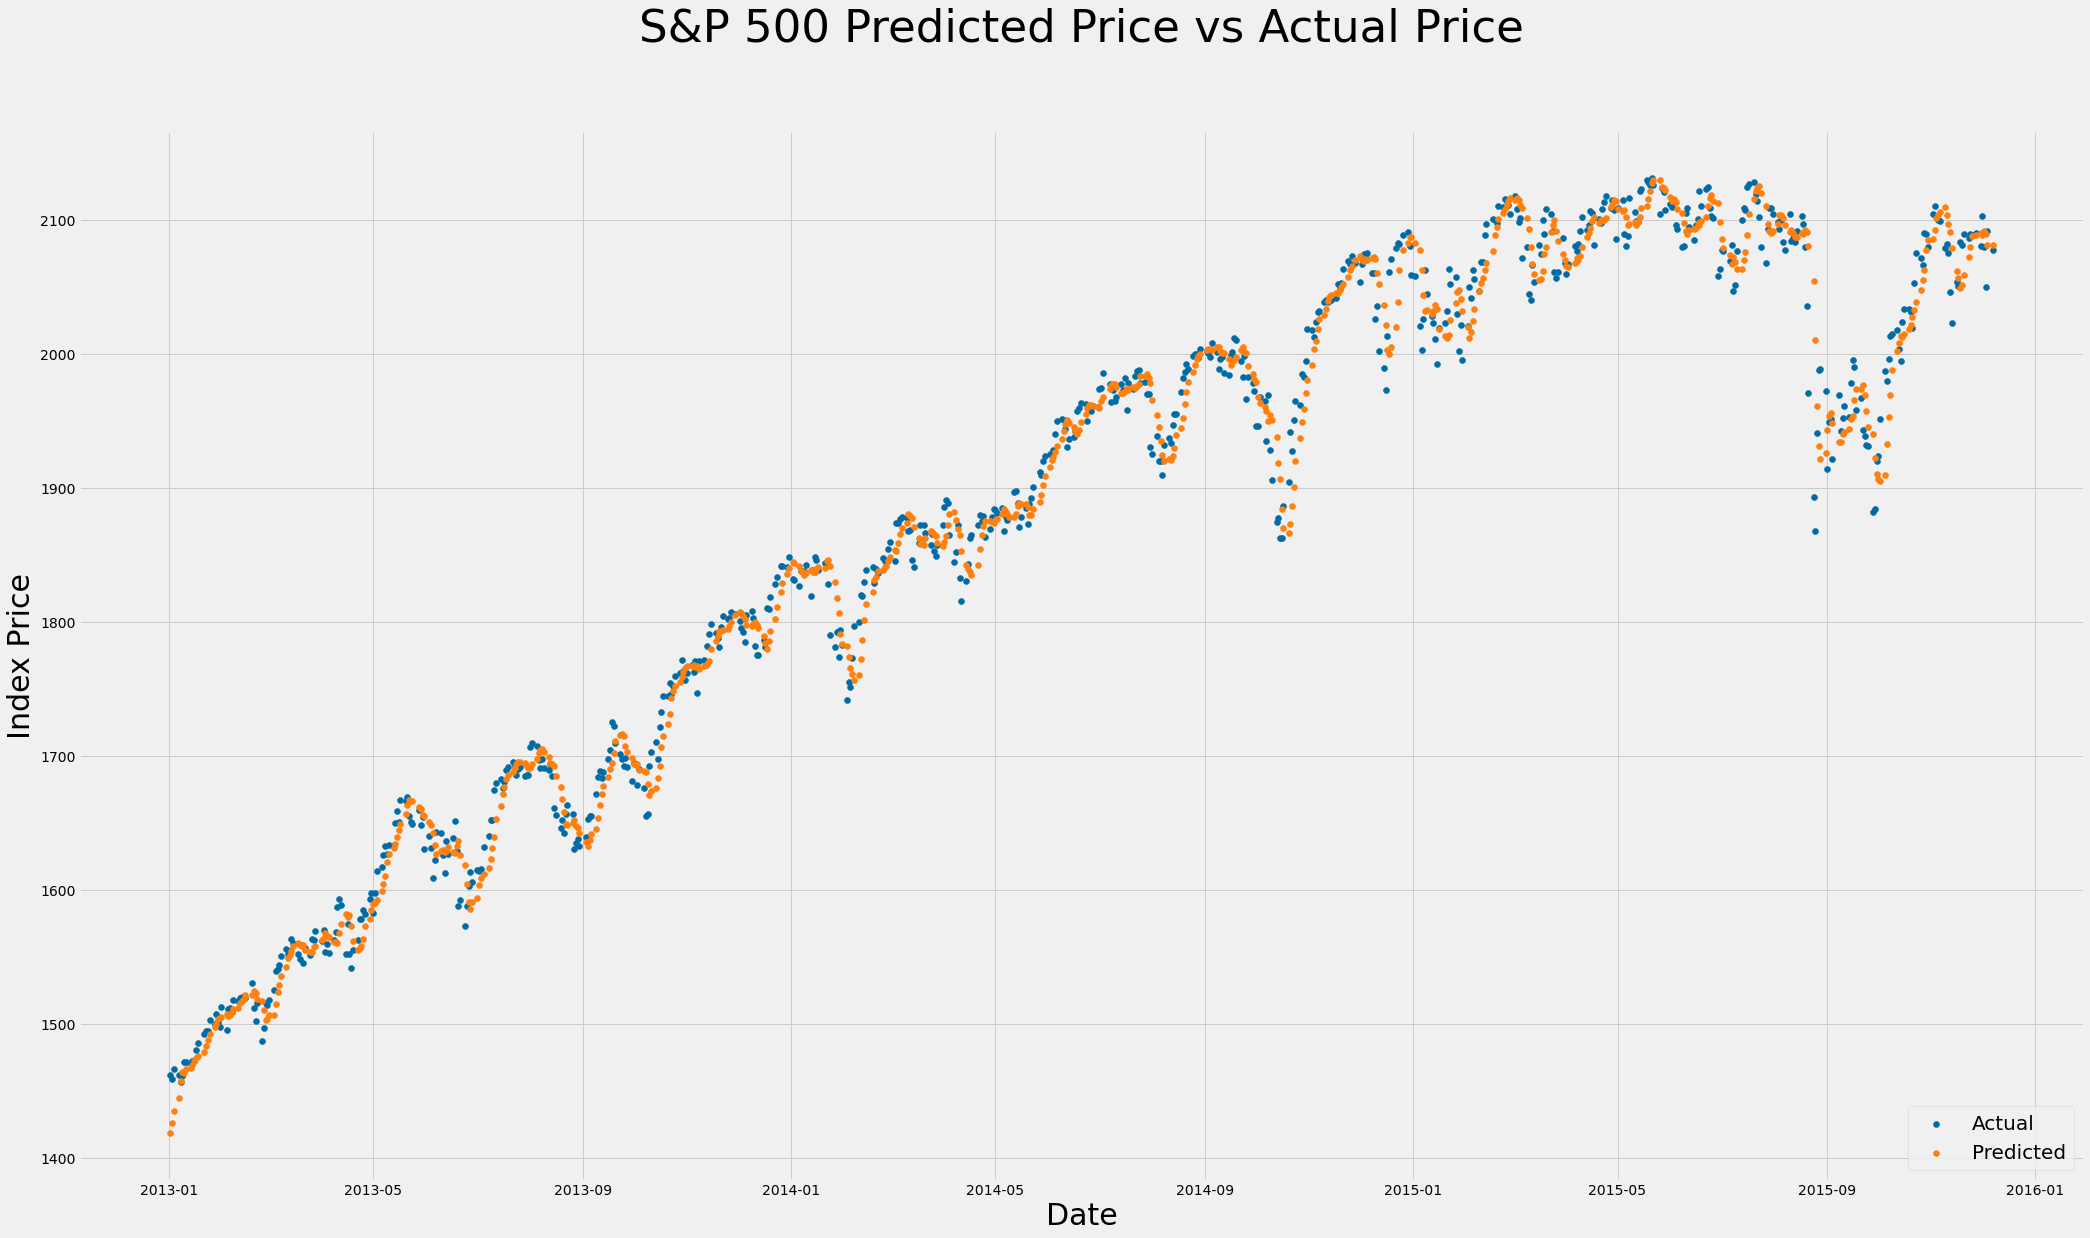

In [8]:
#Changing the figure size and Setting the Color
plt.figure(figsize=(32,18))
cb_dark_blue = (0/255,107/255,164/255)
cb_orange = (255/255, 128/255, 14/255)

#Plotting the values
plt.scatter(test['Date'],test['Close'],label='Actual',color=cb_dark_blue)
plt.scatter(test['Date'],predict1,label='Predicted',color=cb_orange)

#Tweaking the labels
plt.xlabel('Date',fontsize=30)
plt.ylabel('Index Price',fontsize=30)
plt.title('S&P 500 Predicted Price vs Actual Price',y=1.08,fontsize=45)
plt.legend(loc='lower right',fontsize=20)

### Adding Features
The graph above indicates that the model is decent enough to predict stock prices, but let's try adding more features into the mix and see whether there is a decrease in RMSE and MAE. 

The features that we are going to add are:
1.  The average volume of trades in the last 5 days
2.  The average volume of trades in the last year (365 days)
3. The standard deviation volume of trades in the last 5 days
4. The standard deviation volume of trades in the last year (365 days)
5. The standard deviation price of trades in the last 5 days
6. The standard deviation price of trades in the last year (365 days)
7. The ratio between the average price for the past 5 days, and the average price for the past 365 days.
8. The ratio between the volume price for the past 5 days, and the average price for the past 365 days.

We will then use the correlation value to select the features for those indexes with `Close`.

In [9]:
#Creating average volume of trades columns
sp['average_vol_5']=add_indicator(sp,'Volume',5,np.mean)
sp['average_vol_365']=add_indicator(sp,'Volume',365,np.mean)
sp['std_vol_5']=add_indicator(sp,'Volume',5,np.std)
sp['std_vol_365']=add_indicator(sp,'Volume',365,np.std)
sp['std_price_5']=add_indicator(sp,'Close',5,np.std)
sp['std_price_365']=add_indicator(sp,'Close',365,np.std)

#Dropping data 
df=sp[sp['Date']>datetime(1951, 6, 18)].copy()
df.drop(['Adj Close','Low','High','Open','Volume'],axis=1,inplace=True)

#Creating ratio column
df['rat_price']=df['mean_5_day']/df['mean_365_day']
df['rat_vol']=df['average_vol_5']/df['average_vol_365']

In [10]:
#Looking at the correlation value
corr=df.corr()['Close'].abs().sort_values(ascending=False)
corr

Close              1.000000
mean_5_day         0.999793
mean_30_day        0.999189
mean_365_day       0.988870
std_price_365      0.816103
average_vol_365    0.784878
average_vol_5      0.780896
std_price_5        0.722414
std_vol_365        0.684141
std_vol_5          0.617248
rat_price          0.047782
rat_vol            0.012305
Name: Close, dtype: float64

It seems as if the ratio columns have little to no effect to the `Close`, thus we will only use columns with R-value of greater than 0.7 since the other columns will feed future information to the model.

In [13]:
#Splitting the data into train and test
train=df[df['Date']<datetime(2013,1,1)]
test=df[df['Date']>=datetime(2013,1,1)]

#Features that will be used
features=corr[corr > 0.7].index.tolist()
features.remove('Close')

#Training the model
lr=LinearRegression()
lr.fit(train[features],train['Close'])
predict=lr.predict(test[features])

#Finding the RMSE and MAE
mse=mean_squared_error(test['Close'],predict)
rmse=np.sqrt(mse)
mae=mean_absolute_error(test['Close'],predict)
variance=np.var(predict)

print('The Root Mean Squared Value is {}'.format(rmse))
print('The Mean Absolute Error is {}'.format(mae))
print('The Variance is {}'.format(variance))

The Root Mean Squared Value is 22.22411093609128
The Mean Absolute Error is 16.148056540638972
The Variance is 37320.48634192821


It seems like adding additional features have little to no impact to the RMSE and MAE scores. A possible explanation for this is because the correlation value for the original three-feature model already have a high correlation to the `Close` itself. Finally we will plot the final model's actual and predicted value.

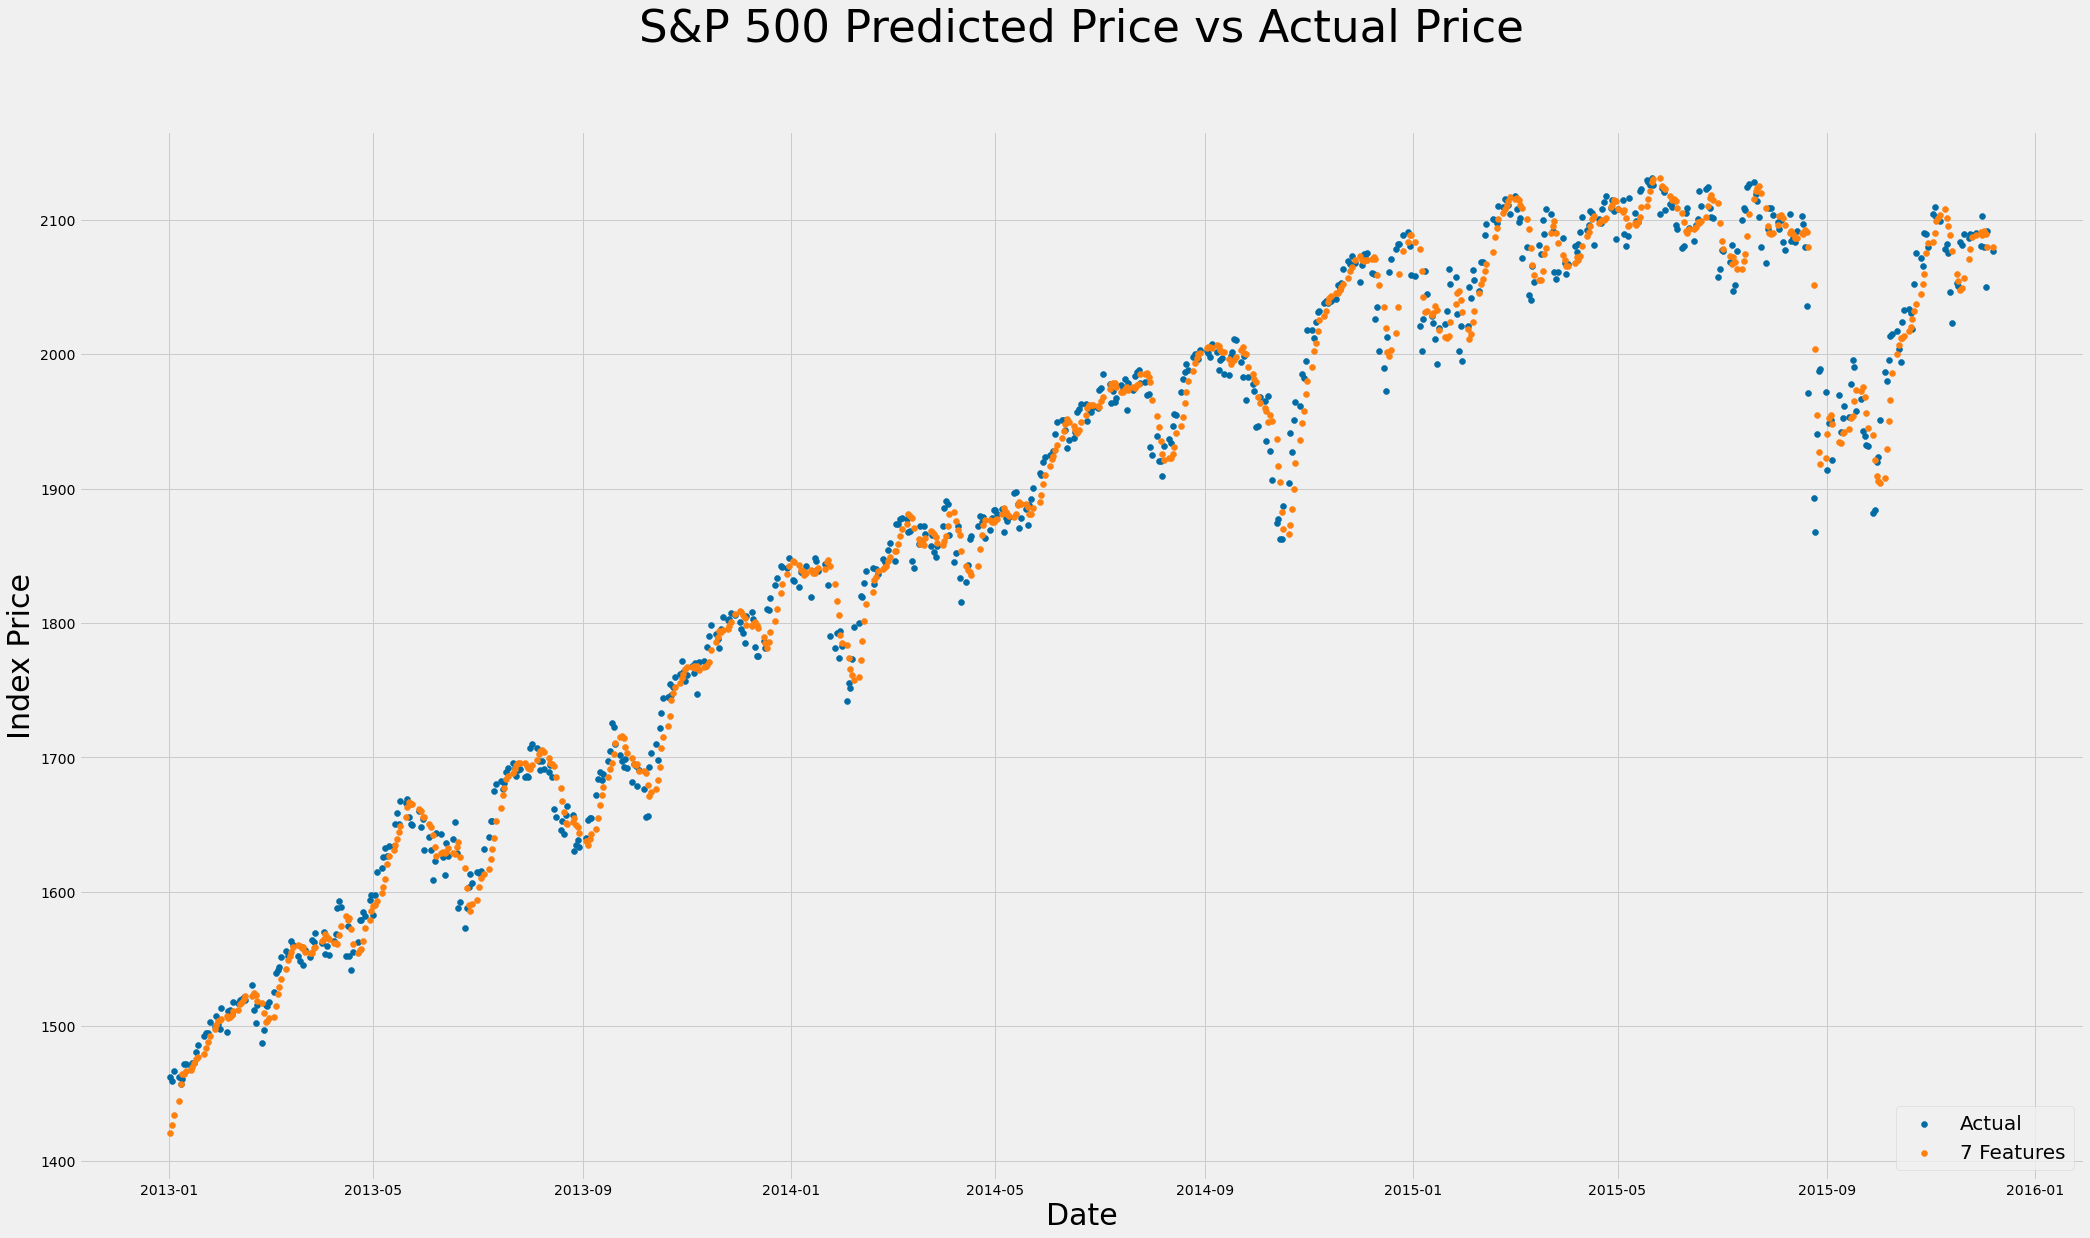

In [12]:
#Changing the figure size and Setting the Color
plt.figure(figsize=(32,18))
cb_dark_blue = (0/255,107/255,164/255)
cb_orange = (255/255, 128/255, 14/255)

#Plotting the values
plt.scatter(test['Date'],test['Close'],label='Actual',color=cb_dark_blue)
plt.scatter(test['Date'],predict,label='7 Features',color=cb_orange)

#Tweaking the labels
plt.xlabel('Date',fontsize=30)
plt.ylabel('Index Price',fontsize=30)
plt.title('S&P 500 Predicted Price vs Actual Price',y=1.08,fontsize=45)
plt.legend(loc='lower right',fontsize=20)

### Conclusion

In this exercise, we learn that using linear regression, we can predict the price of something, in this case it is the S&P 500 Index. Things to note is that if we are using data which is highly correlated with the end target, it will usually not be affected by other additional less-correlated columns.